In [ ]:
import numpy as np
import scipy.io as sio
import h5py
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt, lfilter

In [30]:
folder_of_interest = "length_full"
ROOT_PATH = f"../data/processed/{folder_of_interest}/"

In [31]:
FS_IN = 125
FACTOR = 6

def decimate_signal(x: np.ndarray,
                     fs_in: int = 125,
                     factor: int = 2,
                     cutoff: float = 8.0,
                     numtaps: int = 129,
                     zero_phase: bool = True) -> np.ndarray:
    """
    Down‑sample a 125 Hz PPG (or similar) trace to ~20.833 Hz.

    Parameters
    ----------
    x          : 1‑D numpy array, the raw signal.
    fs_in      : original sampling rate (Hz).  Default 125.
    factor     : integer decimation factor.  125 / 6 ≈ 20.833 Hz.
    cutoff     : anti‑alias low‑pass cutoff (Hz).
                 Should be < 0.8 × new Nyquist ≈ 8 Hz.
    numtaps    : FIR length (odd).  Longer ⇒ sharper roll‑off, more latency.
    zero_phase : if True (default) use filtfilt for zero phase; else
                 use causal lfilter (lower latency, but introduces delay).

    Returns
    -------
    y          : decimated 1‑D numpy array (len(x) // factor samples).
    """
    if x.ndim != 1:
        raise ValueError("Input must be 1‑D")

    # design low‑pass FIR
    h = firwin(numtaps, cutoff, fs=fs_in)

    # apply filter
    filt = filtfilt if zero_phase else lfilter
    x_filt = filt(h, 1.0, x)

    # keep every N‑th sample
    return x_filt[::factor]

In [32]:
# ------------------------------------------------------------------
# 1.  Utility that cleans one 1‑D numpy array -----------------------
# ------------------------------------------------------------------
def clean_signal(arr: np.ndarray) -> np.ndarray | None:
    """
    1) cut off all‑NaN tails at the beginning and end;
    2) interpolate NaNs that remain in the interior;
    3) return float32 array or None if nothing left.
    """
    if arr.ndim != 1:
        raise ValueError("signal must be 1‑D")

    ok = ~np.isnan(arr)
    if not ok.any():                # whole vector is NaN
        return None

    # --- trim ---       
    first, last = ok.argmax(), len(arr) - ok[::-1].argmax()
    arr = arr[first:last].astype("float32")   # copy & cast

    # --- interpolate interior NaNs ---       
    nan_mask = np.isnan(arr)
    if nan_mask.any():
        idx    = np.arange(arr.size)
        arr[nan_mask] = np.interp(idx[nan_mask],             # x‑coords to fill
                                  idx[~nan_mask],            # known x‑coords
                                  arr[~nan_mask])            # known values
    return arr

In [33]:
def convert_mat_to_h5(mat_path, h5_path,fs_in,factor):

    print("Loading", mat_path)
    mat = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)["data"]

    with h5py.File(h5_path, "w") as h5:
        for rec in mat:
            g = h5.create_group(str(rec.fix.rec_id))
            g.attrs["subj_id"]   = str(rec.fix.subj_id)
            g.attrs["af_status"] = int(rec.fix.af_status)

            for sig_name in ["ppg", "ekg", "imp", "abp"]:
                sig_obj = getattr(rec, sig_name, None)
                if not hasattr(sig_obj, "v"):
                    continue

                # ---- clean NaNs ----------------------------
                data = clean_signal(sig_obj.v)
                if data is None:
                    continue

                # ---- optional decimate for PPG -------------
                fs = float(sig_obj.fs)
                if sig_name == "ppg":
                    data = decimate_signal(data, fs_in = fs_in, factor = factor)
                    fs   = fs_in / factor            # 20.833 Hz

                # ---- write dataset -------------------------
                ds = g.create_dataset(sig_name,
                                      data=data.astype("float32"),
                                      compression="gzip", chunks=True)
                ds.attrs["fs"] = fs
                for attr in ["method", "label"]:
                    if hasattr(sig_obj, attr):
                        ds.attrs[attr] = str(getattr(sig_obj, attr))

    print("saved", h5_path)

## Convert NSR Data from Mat to H5

In [34]:
folder_of_interest = "length_full"
NSR_MAT_PATH = os.path.join(ROOT_PATH,"mimic_non_af_data.mat")
NSR_H5_PATH  = os.path.join(ROOT_PATH,"mimic_non_af_data.h5")

convert_mat_to_h5(NSR_MAT_PATH,NSR_H5_PATH,fs_in = FS_IN,factor=FACTOR)

Loading ../data/processed/length_full/mimic_non_af_data.mat
saved ../data/processed/length_full/mimic_non_af_data.h5


Number of recordings: 16
First 3 group IDs: ['p004829-2103-08-30-21-52', 'p013072-2194-01-22-16-13', 'p015852-2148-05-03-18-39']

Inspecting group: p004829-2103-08-30-21-52
  dataset 'ekg': shape=(4286652,), fs=125.0
  dataset 'imp': shape=(4286660,), fs=125.0
  dataset 'ppg': shape=(714444,), fs=20.833333333333332


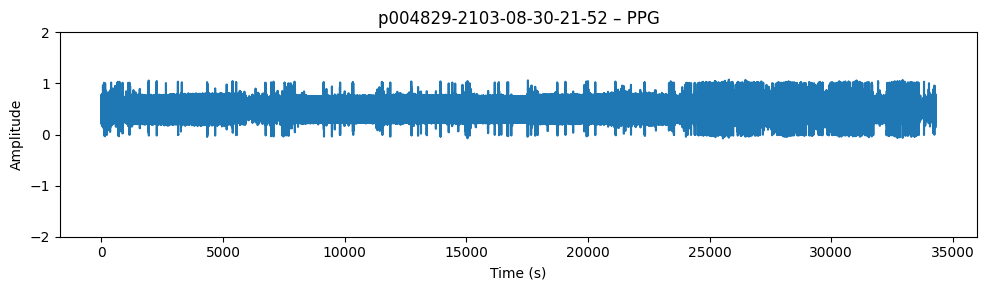

In [35]:
with h5py.File(NSR_H5_PATH, "r") as h5:
    groups = list(h5.keys())
    print("Number of recordings:", len(groups))
    print("First 3 group IDs:", groups[:3])
    first = groups[0]
    print("\nInspecting group:", first)
    for k, ds in h5[first].items():
        print(f"  dataset '{k}': shape={ds.shape}, fs={ds.attrs['fs']}")
        if k == 'ppg':
            fs   = ds.attrs["fs"]          # sampling rate
            sig  = ds[:]                  # load the whole signal
            t    = np.arange(len(sig)) / fs

            nan_mask = np.isnan(sig)        # True where value is NaN
            plt.figure(figsize=(10,3))
            plt.plot(t, sig)
            plt.scatter(t[nan_mask], np.ones(len(sig[nan_mask])), color="r", s=5)
            plt.title(f"{first} – PPG")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.ylim((-2,2))
            plt.show()

with h5py.File(NSR_H5_PATH, "r") as h5:
    grp   = h5["p004829-2103-08-30-21-52"]
    ekg   = grp["ekg"][:]          # NumPy array
    fs    = grp["ekg"].attrs["fs"] # 125 Hz
    label = grp.attrs["af_status"] # 0 = non‑AF

## Convert AF Data from Mat to H5

In [36]:
AF_MAT_PATH = os.path.join(ROOT_PATH,"mimic_af_data.mat")
AF_H5_PATH    = os.path.join(ROOT_PATH,"mimic_af_data.h5")

convert_mat_to_h5(AF_MAT_PATH,AF_H5_PATH,fs_in = 125,factor=2)

Loading ../data/processed/length_full/mimic_af_data.mat
saved ../data/processed/length_full/mimic_af_data.h5


Number of recordings: 19
First 3 group IDs: ['p000946-2120-05-14-08-08', 'p022954-2136-02-29-17-52', 'p025117-2202-03-15-20-28']

Inspecting group: p000946-2120-05-14-08-08
  dataset 'abp': shape=(1405375,), fs=125.0
  dataset 'ekg': shape=(1405375,), fs=125.0
  dataset 'imp': shape=(1405375,), fs=125.0
  dataset 'ppg': shape=(702688,), fs=62.5


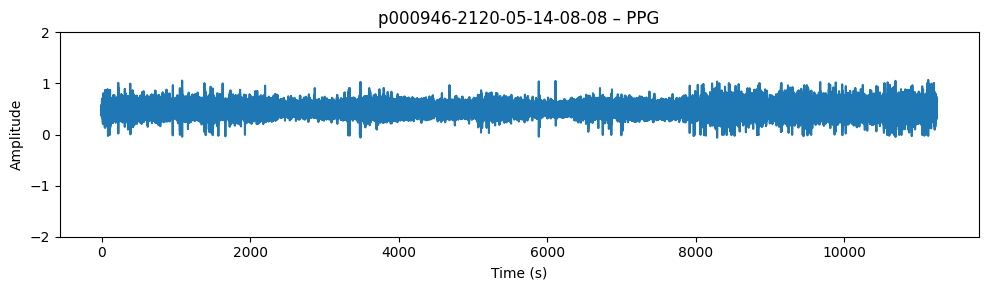

/


In [37]:
with h5py.File(AF_H5_PATH, "r") as h5:
    groups = list(h5.keys())
    print("Number of recordings:", len(groups))
    print("First 3 group IDs:", groups[:3])
    first = groups[0]
    print("\nInspecting group:", first)
    for k, ds in h5[first].items():
        print(f"  dataset '{k}': shape={ds.shape}, fs={ds.attrs['fs']}")
        if k == 'ppg':
            fs   = ds.attrs["fs"]          # sampling rate
            sig  = ds[:]                  # load the whole signal
            t    = np.arange(len(sig)) / fs

            nan_mask = np.isnan(sig)        # True where value is NaN
            plt.figure(figsize=(10,3))
            plt.plot(t, sig)
            plt.scatter(t[nan_mask], np.ones(len(sig[nan_mask])), color="r", s=5)
            plt.title(f"{first} – PPG")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.ylim((-2,2))
            plt.show()

with h5py.File(AF_H5_PATH, "r") as h5:
    print(h5.name)
    grp   = h5["p000946-2120-05-14-08-08"]
    ekg   = grp["ekg"][:]          # NumPy array
    fs    = grp["ekg"].attrs["fs"] # 125 Hz
    label = grp.attrs["af_status"] # 0 = non‑AF


In [38]:
def build_split_h5(src_paths, out_path, selected_ids):
    """
    Copy only groups in selected_ids from each src H5 into a new H5 at out_path,
    preserving all dataset contents and attributes.
    """
    with h5py.File(out_path, 'w') as dst:
        for src_path in src_paths:
            with h5py.File(src_path, 'r') as src:
                for gid, grp in src.items():
                    if gid not in selected_ids:
                        continue
                    # replicate group
                    dst_grp = dst.create_group(gid)
                    # copy group attrs
                    for k, v in grp.attrs.items():
                        dst_grp.attrs[k] = v
                    # copy every dataset in that group
                    for ds_name, ds in grp.items():
                        if not isinstance(ds, h5py.Dataset):
                            continue
                        data = ds[()]  # read full array into memory
                        dst_ds = dst_grp.create_dataset(
                            ds_name,
                            data=data,
                            compression='gzip',
                            chunks=True
                        )
                        # copy dataset attributes
                        for ak, av in ds.attrs.items():
                            dst_ds.attrs[ak] = av

In [39]:
OUT_H5_TRAIN  = os.path.join(ROOT_PATH,"train_ds.h5")
OUT_H5_TEST   = os.path.join(ROOT_PATH,"test_ds.h5")

TRAIN_RATIO = 0.8
RNG_SEED    = 42

# ── helper to collect all groups with labels ────────────────────
def collect_groups(path: str, label: int):
    rows = []
    with h5py.File(path, 'r') as h5:
        for gid in h5:
            subj = str(h5[gid].attrs.get('subj_id', gid.split('-')[0]))
            rows.append(dict(file=path, group_id=gid, subj_id=subj, label=label))
    return rows

# ── build a DataFrame and stratified split by subject ───────────
rows = collect_groups(NSR_H5_PATH, 0) + collect_groups(AF_H5_PATH, 1)
meta = pd.DataFrame(rows)

random.seed(RNG_SEED)
subjects = meta.subj_id.unique().tolist()
random.shuffle(subjects)
cut = int(len(subjects) * TRAIN_RATIO)
train_subj = set(subjects[:cut])

meta['split'] = np.where(meta.subj_id.isin(train_subj), 'train', 'test')
print(meta.split.value_counts())

# ── re‑use your previously defined build_split_h5 ───────────────
def build_split_h5(src_paths, out_path, selected_ids):
    if os.path.exists(out_path):
        os.remove(out_path)
    with h5py.File(out_path, 'w') as dst:
        for src_path in src_paths:
            with h5py.File(src_path, 'r') as src:
                for gid, grp in src.items():
                    if gid not in selected_ids:
                        continue
                    # copy entire group (datasets + attrs)
                    src.copy(grp, dst, name=gid, without_attrs=False)
                    # then ensure our 'label' attr is set/overwritten:
                    dst[gid].attrs['label'] = int(grp.attrs.get('af_status', grp.attrs.get('label', 0)))

# ── extract group IDs per split and write out ────────────────────
train_ids = meta.loc[meta.split=='train', 'group_id'].tolist()
test_ids  = meta.loc[meta.split=='test',  'group_id'].tolist()

build_split_h5([NSR_H5_PATH, AF_H5_PATH], OUT_H5_TRAIN, train_ids)
build_split_h5([NSR_H5_PATH, AF_H5_PATH], OUT_H5_TEST,  test_ids)

print("train_ds.h5 and test_ds.h5 created.")

split
train    28
test      7
Name: count, dtype: int64
train_ds.h5 and test_ds.h5 created.


In [44]:
t1 = h5py.File(OUT_H5_TRAIN, 'r', swmr=True)
idxs = list(t1.keys())
print(t1[idxs[0]]['ppg'][:].astype('float32').shape)
print(t1[idxs[0]].attrs.get('af_status'))

(702688,)
1
